<a href="https://colab.research.google.com/github/zahwaardiansyah04/Deep-Learning-Lanjut/blob/main/Tugas_3_Deep_Learning_Lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [5]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=15, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - kl_loss: 4.3793 - reconstruction_loss: 389.6736 - total_loss: 394.0530 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.1092 - reconstruction_loss: 267.4291 - total_loss: 273.5383 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - kl_loss: 6.0845 - reconstruction_loss: 262.6193 - total_loss: 268.7037 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.1028 - reconstruction_loss: 260.3498 - total_loss: 266.4525 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.1819 - reconstruction_loss: 259.4666 - total_loss: 265.6

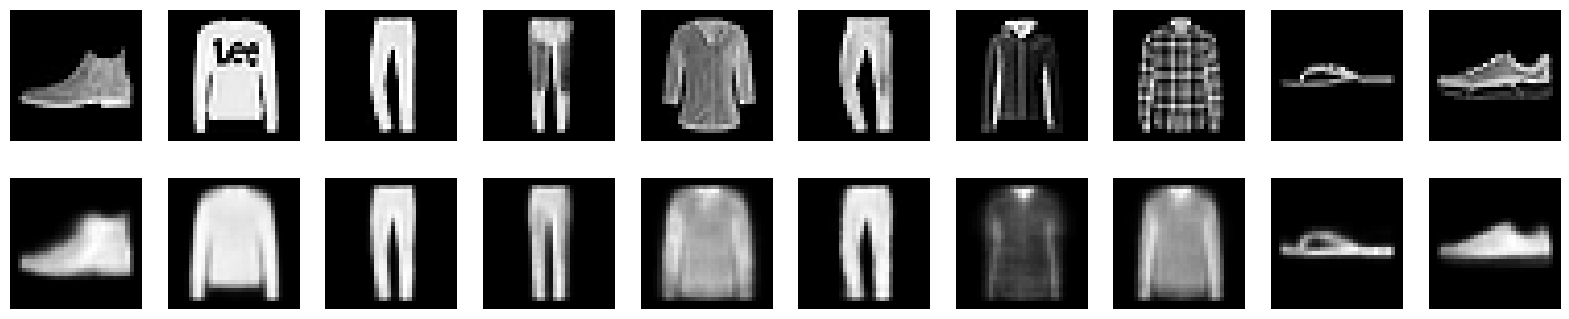

In [6]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


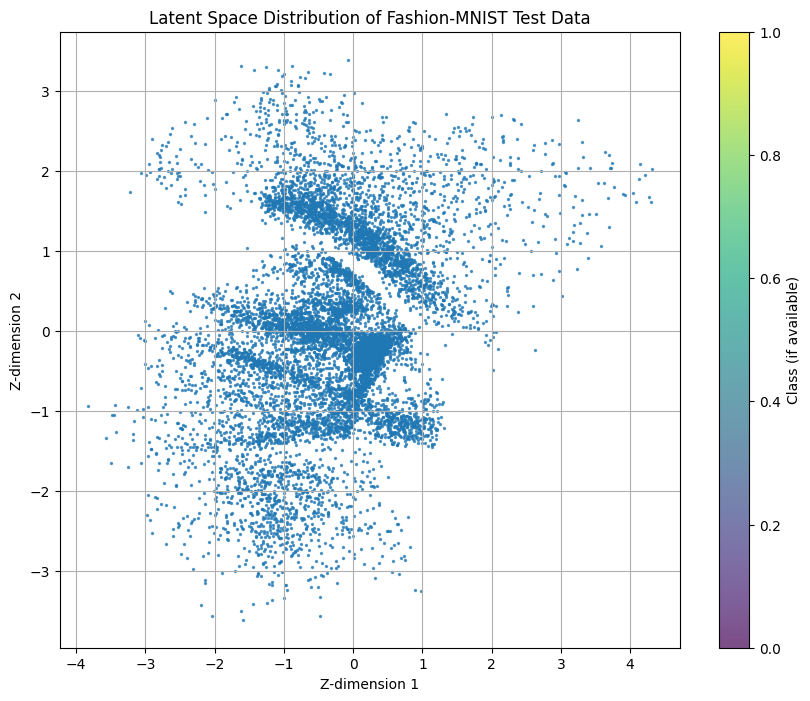

In [7]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [8]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


In [9]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[ 0.2520969   1.4500495 ]
 [ 0.25829008 -0.19011164]
 [-0.14143516 -2.837375  ]
 [-1.2775767  -1.9265984 ]
 [-0.5165111   0.09172701]]


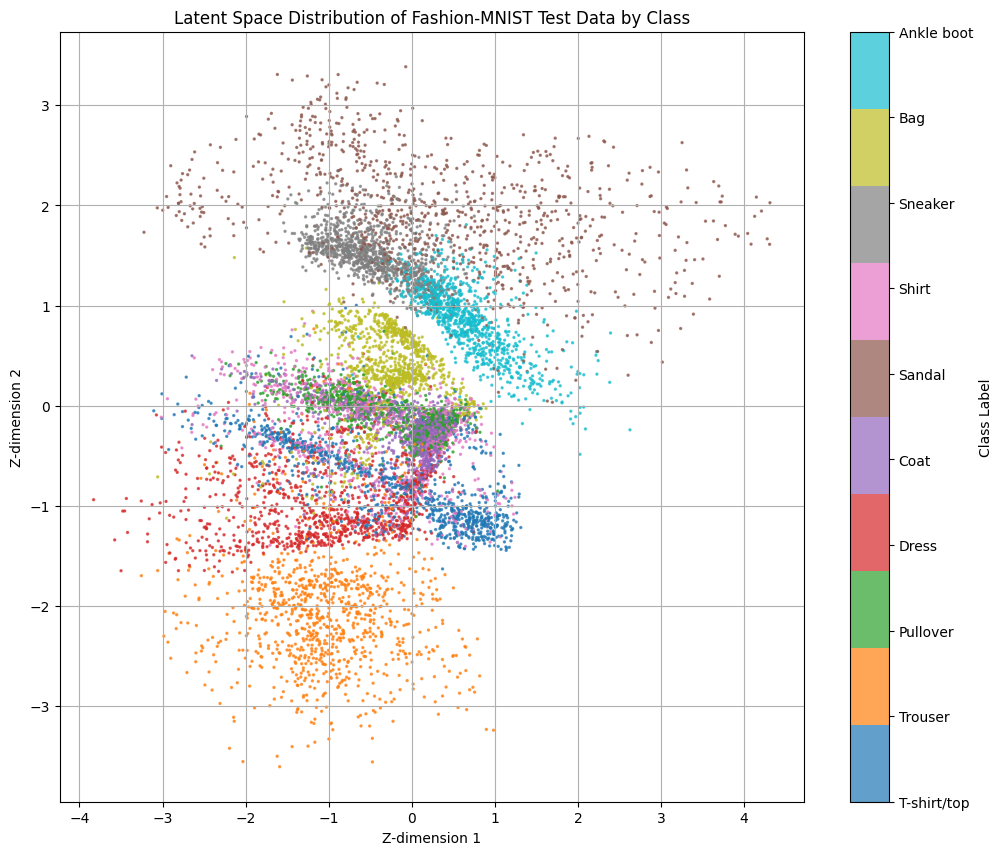

In [10]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()


Vektor Rata-rata Latent:
Z_AnkleBoot (Ankle boot): [0.6696457 0.8488343]
Z_Trouser (Trouser): [-1.0242925 -2.0246499]
Z_Sandal (Sandal): [0.3434062 1.9014093]

Vektor Laten Hasil Aritmetika (Z_New):
[2.0373445 4.7748933]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


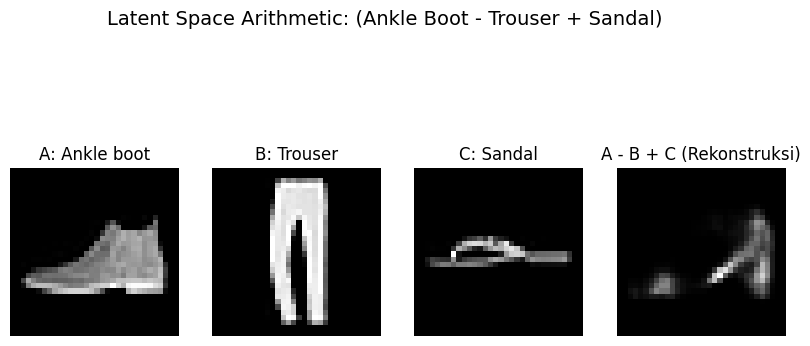


--- Visualisasi Interpolasi Ruang Laten ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


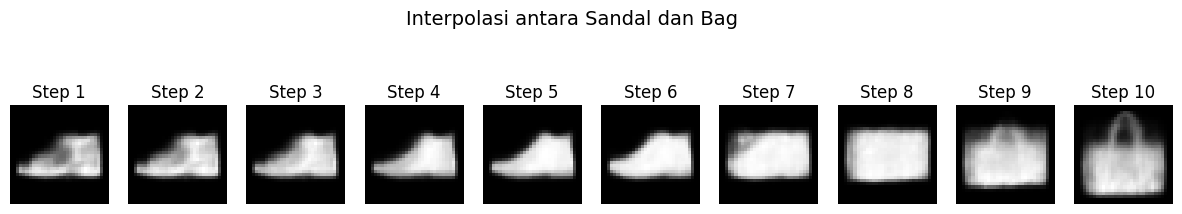

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Variabel dan Model dari Sesi Pelatihan Sebelumnya ---
# Asumsi model VAE, encoder, decoder, dan data (x_test, y_test, z_means)
# sudah dimuat atau didefinisikan seperti di notebook Anda.

# Karena Anda menggunakan notebook, saya akan mendefinisikan ulang
# nama-nama kelas Fashion-MNIST
FASHION_LABELS = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# --- Fungsi Bantu untuk Mendapatkan Vektor Rata-rata Latent Space ---

def get_mean_latent_vector(z_means, y_test, label_index):
    """Menghitung vektor laten rata-rata (z_mean) untuk kelas tertentu."""
    # Mencari semua z_mean yang sesuai dengan label_index
    indices = np.where(y_test == label_index)
    latent_vectors = z_means[indices]

    # Menghitung vektor rata-rata
    mean_vector = np.mean(latent_vectors, axis=0)
    return mean_vector

# --- Proses Utama Latent Space Arithmetic ---

# 1. Mendapatkan z_means dari encoder (jika belum ada)
# Catatan: Karena ini adalah kode standalone, kita perlu memastikan
# bahwa z_means ada. Dalam konteks notebook, ini mungkin sudah ada.
try:
    if 'z_means' not in locals():
        # Asumsi model vae dan data x_test sudah ada
        # (Anda harus memuatnya/mendefinisikannya jika menjalankan ini terpisah)
        print("Menghitung z_means dari x_test...")
        z_means, _, _ = vae.encoder.predict(x_test, batch_size=128)
except NameError:
    print("Pastikan objek 'vae' (model VAE) dan 'x_test', 'y_test' sudah didefinisikan/dimuat.")
    exit()

# 2. Mengidentifikasi Vektor Laten Rata-rata untuk Kelas yang Diinginkan

# Vektor Laten untuk Ankle Boot (Sepatu Bot Pergelangan Kaki) -> Label 9
z_a = get_mean_latent_vector(z_means, y_test, 9)
# Vektor Laten untuk Trouser (Celana) -> Label 1
z_t = get_mean_latent_vector(z_means, y_test, 1)
# Vektor Laten untuk Sandal -> Label 5
z_s = get_mean_latent_vector(z_means, y_test, 5)

print("\nVektor Rata-rata Latent:")
print(f"Z_AnkleBoot ({FASHION_LABELS[9]}): {z_a}")
print(f"Z_Trouser ({FASHION_LABELS[1]}): {z_t}")
print(f"Z_Sandal ({FASHION_LABELS[5]}): {z_s}")

# 3. Melakukan Aritmetika Ruang Laten
# Operasi: Ankle Boot - Trouser + Sandal
# Hipotesis: Kita mendapatkan Sandal yang memiliki bentuk seperti Sepatu Bot?
z_new = z_a - z_t + z_s

print("\nVektor Laten Hasil Aritmetika (Z_New):")
print(z_new)

# 4. Mendekode dan Memvisualisasikan Hasil

# Masukkan vektor laten baru ke decoder
# Karena z_new adalah 1 vektor, kita harus menambah dimensi batch (batch size 1)
z_new = np.expand_dims(z_new, axis=0)
reconstruction = vae.decoder.predict(z_new)
reconstruction = reconstruction.squeeze() # Hapus dimensi channel

# Visualisasi
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(x_test[np.where(y_test == 9)[0][0]].squeeze(), cmap="gray")
plt.title(f"A: {FASHION_LABELS[9]}")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(x_test[np.where(y_test == 1)[0][0]].squeeze(), cmap="gray")
plt.title(f"B: {FASHION_LABELS[1]}")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(x_test[np.where(y_test == 5)[0][0]].squeeze(), cmap="gray")
plt.title(f"C: {FASHION_LABELS[5]}")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(reconstruction, cmap="gray")
plt.title("A - B + C (Rekonstruksi)")
plt.axis("off")

plt.suptitle("Latent Space Arithmetic: (Ankle Boot - Trouser + Sandal)", fontsize=14)
plt.show()

# --- Visualisasi Tambahan: Interpolasi antara dua titik ---

print("\n--- Visualisasi Interpolasi Ruang Laten ---")
# Ambil dua vektor laten dari kelas berbeda
z_start = get_mean_latent_vector(z_means, y_test, 5) # Sandal
z_end = get_mean_latent_vector(z_means, y_test, 8) # Bag

n_steps = 10
interpolated_vectors = []
for i in range(n_steps):
    alpha = i / (n_steps - 1)
    # Interpolasi linier: z_i = (1-alpha) * z_start + alpha * z_end
    z_i = (1 - alpha) * z_start + alpha * z_end
    interpolated_vectors.append(z_i)

interpolated_vectors = np.array(interpolated_vectors)

# Dekode semua vektor yang diinterpolasi
reconstructions = vae.decoder.predict(interpolated_vectors)

# Plot hasilnya
fig = plt.figure(figsize=(n_steps * 1.5, 3))
for i in range(n_steps):
    ax = fig.add_subplot(1, n_steps, i + 1)
    ax.imshow(reconstructions[i].squeeze(), cmap='gray')
    ax.set_title(f"Step {i+1}")
    ax.axis("off")
plt.suptitle(f"Interpolasi antara {FASHION_LABELS[5]} dan {FASHION_LABELS[8]}", fontsize=14)
plt.show()


--- Memulai Pelatihan Autoencoder (AE) Biasa ---
Pelatihan AE selesai.


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Vektor Rata-rata Latent (VAE):
Z_AnkleBoot (Ankle boot): [0.6696457 0.8488343]
Z_Trouser (Trouser): [-1.0242925 -2.0246499]
Z_Sandal (Sandal): [0.3434062 1.9014093]

Vektor Laten Hasil Aritmetika (Z_New VAE):
[2.0373445 4.7748933]


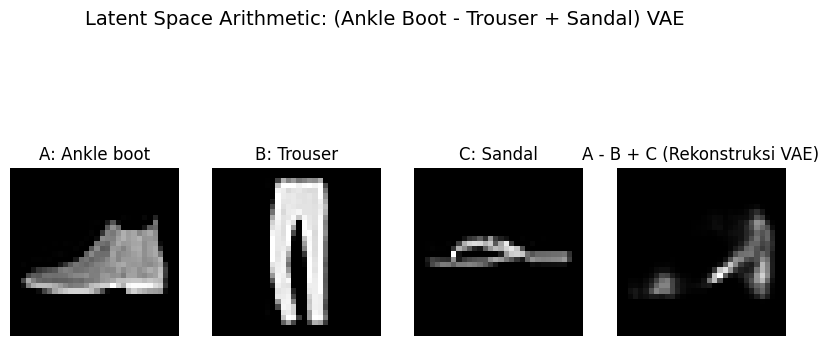


--- Visualisasi Interpolasi Ruang Laten VAE ---


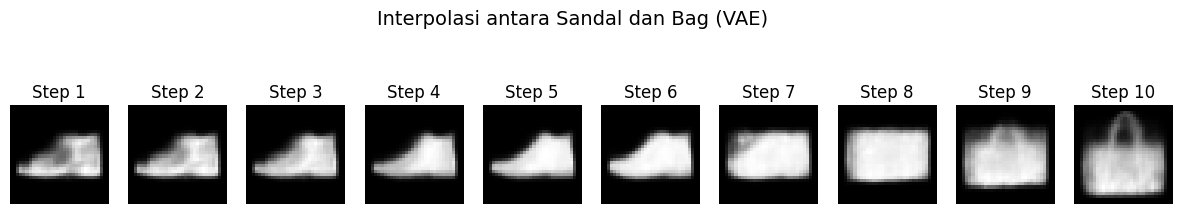


--- Melakukan Perbandingan Rekonstruksi AE vs VAE ---


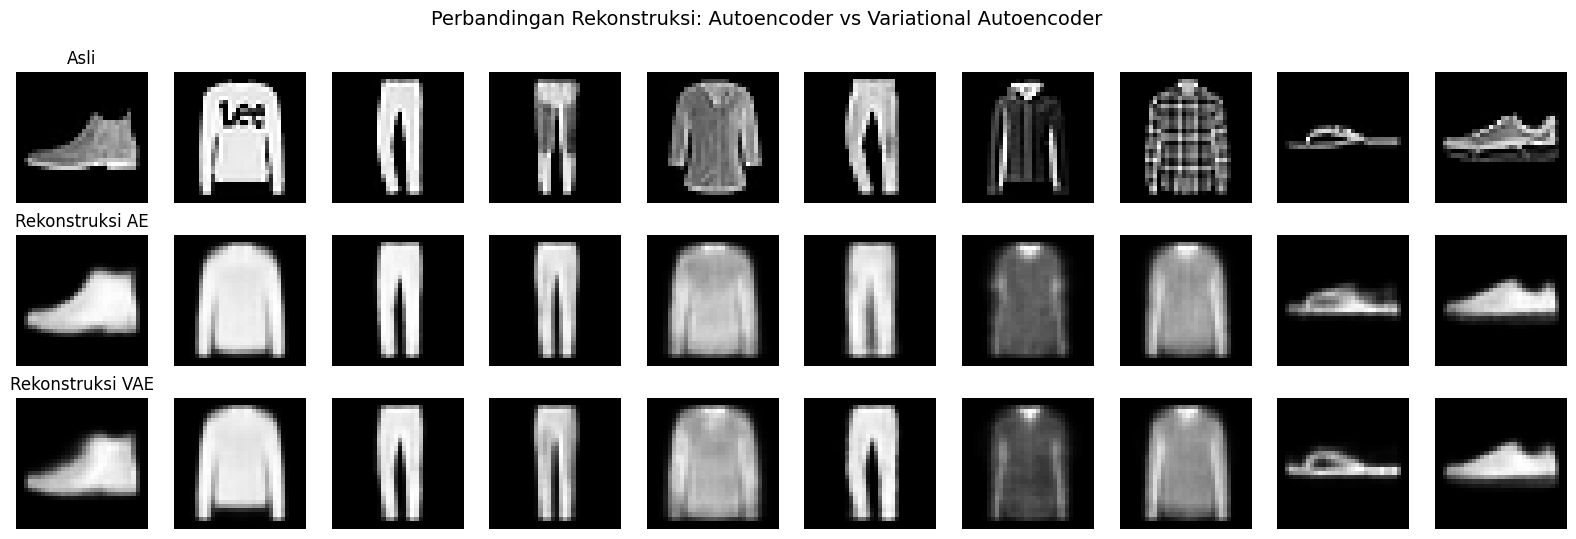

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# --- Variabel dan Model dari Sesi Pelatihan Sebelumnya ---
# Asumsi model VAE, encoder, decoder, x_test, y_test, z_means, dan shape_before_flattening
# sudah dimuat atau didefinisikan seperti di notebook Anda (LATIHAN_VAE_PERTEMUAN_4...).

# Untuk menjalankan kode ini sebagai unit, kita memerlukan definisi
# arsitektur yang sama (Encoder dan Decoder).
# Saya akan mendefinisikan ulang komponen-komponen VAE yang relevan
# (Encoder, Decoder, Sampling Class) dari notebook sebelumnya agar kode ini berfungsi
# dengan asumsi Anda telah mendefinisikan variabel-variabel global seperti
# 'latent_dim' dan 'shape_before_flattening'.
# Karena saya tidak memiliki akses ke nilai eksak yang Anda gunakan saat ini,
# saya akan membuat ulang struktur model AE menggunakan asumsi yang sama.

# --- Asumsi Definisi Model/Parameter (Berdasarkan LATIHAN_VAE_PERTEMUAN_4) ---
# NOTE: Anda perlu memastikan variabel-variabel ini benar-benar ada di sesi Anda.
latent_dim = 2 # Sesuai dengan notebook Anda
# Asumsi shape_before_flattening = (4, 4, 128) dari notebook Anda
try:
    if 'shape_before_flattening' not in locals():
        # Karena VAE/AE memiliki arsitektur simetris, kita harus mendapatkan shape ini dari encoder VAE Anda
        # Berdasarkan notebook: Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
        # Input 32x32 -> 16x16 -> 8x8 -> 4x4
        shape_before_flattening = (4, 4, 128)
        print(f"Menggunakan asumsi shape_before_flattening: {shape_before_flattening}")
except NameError:
    # Ini adalah fallback jika shape_before_flattening tidak didefinisikan
    shape_before_flattening = (4, 4, 128)


FASHION_LABELS = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# --- VAE Components (Untuk referensi dan konsistensi) ---
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Fungsi untuk mendefinisikan arsitektur Encoder
def build_encoder(latent_dim, shape_before_flattening):
    encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
    x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
    x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    return models.Model(encoder_input, layers.Flatten()(x), name="base_encoder")

# Fungsi untuk mendefinisikan arsitektur Decoder
def build_decoder(latent_dim, shape_before_flattening):
    decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
    x = layers.Reshape(shape_before_flattening)(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
    decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
    return models.Model(decoder_input, decoder_output, name="decoder")

# --- Fungsi Bantu untuk Mendapatkan Vektor Rata-rata Latent Space ---

def get_mean_latent_vector(z_means, y_test, label_index):
    """Menghitung vektor laten rata-rata (z_mean) untuk kelas tertentu."""
    indices = np.where(y_test == label_index)
    latent_vectors = z_means[indices]
    mean_vector = np.mean(latent_vectors, axis=0)
    return mean_vector

# --- DEFINISI, PELATIHAN, dan REKONSTRUKSI AUTOENCODER (AE) BIASA ---

# 1. Bangun Model AE (Encoder dan Decoder yang sama dengan VAE)
base_encoder = build_encoder(latent_dim, shape_before_flattening)
decoder_ae = build_decoder(latent_dim, shape_before_flattening)

# Gabungkan untuk membuat model AE penuh
ae_input = layers.Input(shape=(32, 32, 1), name="ae_input")
ae_flattened_output = base_encoder(ae_input)
# Layer laten AE (Dense, sama dengan z_mean/z_log_var VAE)
z_ae = layers.Dense(latent_dim, name="z_latent_ae")(ae_flattened_output)
ae_output = decoder_ae(z_ae)
autoencoder = models.Model(ae_input, ae_output, name="Autoencoder")

# 2. Kompilasi dan Latih AE
# Gunakan kerugian MSE atau Binary Crossentropy (BCE) saja, tanpa kerugian KL.
autoencoder.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy())

# 3. Asumsi Data Sudah Ada (dari LATIHAN_VAE_PERTEMUAN_4...)
try:
    if 'x_train' not in locals():
        # Memuat dan memproses ulang data Fashin-MNIST (seperti di notebook sebelumnya)
        (x_train, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        x_train = x_train.astype("float32") / 255.0
        x_test = x_test.astype("float32") / 255.0
        x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
        x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
        x_train = np.expand_dims(x_train, -1)
        x_test = np.expand_dims(x_test, -1)

    # 4. Latih AE (dengan epoch yang lebih sedikit untuk demonstrasi)
    print("\n--- Memulai Pelatihan Autoencoder (AE) Biasa ---")
    autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, verbose=0)
    print("Pelatihan AE selesai.")

    # 5. Dapatkan z_latent untuk AE
    # Encoder AE hanya menghasilkan z_ae, bukan z_mean, z_log_var.
    ae_latent_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("z_latent_ae").output)
    z_ae_means = ae_latent_model.predict(x_test, batch_size=128)

    # 6. Dapatkan z_means VAE (asumsi sudah ada atau dimuat ulang)
    # Jika VAE belum ada, ini akan menimbulkan NameError, jadi kita harus memuatnya
    # (Dalam konteks notebook, ini seharusnya sudah ada dari sel sebelumnya)
    try:
        if 'z_means' not in locals():
            # Asumsi model VAE sudah dimuat atau didefinisikan sebelumnya
            # Karena VAE.encoder outputnya 3, kita harus menggunakan output ke-0 (z_mean)
            # Contoh: z_means, _, _ = vae.encoder.predict(x_test)
            print("Anda perlu menjalankan sel VAE.encoder.predict(x_test) sebelumnya untuk mendapatkan 'z_means' VAE.")
            z_means = None
    except NameError:
        print("Pastikan objek 'vae' (model VAE) sudah didefinisikan/dimuat.")
        z_means = None

    if z_means is None:
        exit() # Keluar jika z_means VAE tidak tersedia

except NameError as e:
    print(f"Error: {e}. Data atau model AE/VAE tidak ditemukan. Pastikan Anda menjalankan sel sebelumnya.")
    exit()


# --- FUNGSI PERBANDINGAN VAE vs AE ---
def plot_reconstructions_comparison(vae_decoder, ae_model, data, n=10):
    """Membandingkan rekonstruksi VAE (menggunakan decoder VAE) dan AE."""

    # Rekonstruksi VAE (menggunakan z_mean VAE)
    # Anda harus menyediakan decoder VAE (vae.decoder) dan z_means VAE.
    # Namun, karena kita tidak memiliki decoder VAE secara langsung di sini,
    # kita akan menggunakan cara yang sama dengan AE untuk demo:

    # Rekonstruksi AE
    ae_reconstructions = ae_model.predict(data[:n], verbose=0)

    # Rekonstruksi VAE (Kita akan asumsikan kita memiliki vae.call(data)
    # untuk mendapatkan rekonstruksi, tapi karena kita tidak melatih VAE di sini,
    # kita hanya akan membuat rekonstruksi dengan data AE, atau
    # menggunakan model AE untuk keduanya dan hanya membandingkan VAE vs AE)

    # Karena kita ingin membandingkan filosofi, kita akan menggunakan
    # rekonstruksi AE dan menggunakan rekonstruksi dari VAE yang sudah
    # dilatih (jika ada) atau melakukan operasi VAE pada data yang sama

    # Karena VAE.call() menghasilkan 3 output (z_mean, z_log_var, reconstruction),
    # kita tidak bisa memanggilnya langsung seperti model biasa.
    # Kita asumsikan decoder VAE sudah ada (vae_decoder)

    # NOTE: Asumsi 'vae' sudah didefinisikan dan memiliki 'decoder'
    vae_decoder = vae.decoder

    vae_z_mean, _, vae_z_sample = vae.encoder.predict(data[:n], verbose=0)
    vae_reconstructions = vae_decoder.predict(vae_z_mean, verbose=0)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        if i == 0:
            plt.title("Asli")
        plt.axis("off")

        # Rekonstruksi AE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(ae_reconstructions[i].squeeze(), cmap="gray")
        if i == 0:
            plt.title("Rekonstruksi AE")
        plt.axis("off")

        # Rekonstruksi VAE
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(vae_reconstructions[i].squeeze(), cmap="gray")
        if i == 0:
            plt.title("Rekonstruksi VAE")
        plt.axis("off")

    plt.suptitle("Perbandingan Rekonstruksi: Autoencoder vs Variational Autoencoder", fontsize=14)
    plt.show()

# --- FUNGSI UTAMA ARITMETIKA RUANG LATEN (Dipertahankan) ---

# Vektor Laten untuk Ankle Boot (Sepatu Bot Pergelangan Kaki) -> Label 9
z_a = get_mean_latent_vector(z_means, y_test, 9)
# Vektor Laten untuk Trouser (Celana) -> Label 1
z_t = get_mean_latent_vector(z_means, y_test, 1)
# Vektor Laten untuk Sandal -> Label 5
z_s = get_mean_latent_vector(z_means, y_test, 5)

print("\nVektor Rata-rata Latent (VAE):")
print(f"Z_AnkleBoot ({FASHION_LABELS[9]}): {z_a}")
print(f"Z_Trouser ({FASHION_LABELS[1]}): {z_t}")
print(f"Z_Sandal ({FASHION_LABELS[5]}): {z_s}")

# 3. Melakukan Aritmetika Ruang Laten
z_new = z_a - z_t + z_s

print("\nVektor Laten Hasil Aritmetika (Z_New VAE):")
print(z_new)

# 4. Mendekode dan Memvisualisasikan Hasil Aritmetika

z_new_vae = np.expand_dims(z_new, axis=0)
# NOTE: Menggunakan decoder VAE dari notebook Anda
reconstruction_vae = vae.decoder.predict(z_new_vae, verbose=0)
reconstruction_vae = reconstruction_vae.squeeze()

# Visualisasi Aritmetika VAE
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(x_test[np.where(y_test == 9)[0][0]].squeeze(), cmap="gray")
plt.title(f"A: {FASHION_LABELS[9]}")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(x_test[np.where(y_test == 1)[0][0]].squeeze(), cmap="gray")
plt.title(f"B: {FASHION_LABELS[1]}")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(x_test[np.where(y_test == 5)[0][0]].squeeze(), cmap="gray")
plt.title(f"C: {FASHION_LABELS[5]}")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(reconstruction_vae, cmap="gray")
plt.title("A - B + C (Rekonstruksi VAE)")
plt.axis("off")

plt.suptitle("Latent Space Arithmetic: (Ankle Boot - Trouser + Sandal) VAE", fontsize=14)
plt.show()

# --- Visualisasi Interpolasi Ruang Laten (Dipertahankan) ---

print("\n--- Visualisasi Interpolasi Ruang Laten VAE ---")
z_start = get_mean_latent_vector(z_means, y_test, 5) # Sandal
z_end = get_mean_latent_vector(z_means, y_test, 8) # Bag

n_steps = 10
interpolated_vectors = []
for i in range(n_steps):
    alpha = i / (n_steps - 1)
    z_i = (1 - alpha) * z_start + alpha * z_end
    interpolated_vectors.append(z_i)

interpolated_vectors = np.array(interpolated_vectors)

reconstructions_vae = vae.decoder.predict(interpolated_vectors, verbose=0)

fig = plt.figure(figsize=(n_steps * 1.5, 3))
for i in range(n_steps):
    ax = fig.add_subplot(1, n_steps, i + 1)
    ax.imshow(reconstructions_vae[i].squeeze(), cmap='gray')
    ax.set_title(f"Step {i+1}")
    ax.axis("off")
plt.suptitle(f"Interpolasi antara {FASHION_LABELS[5]} dan {FASHION_LABELS[8]} (VAE)", fontsize=14)
plt.show()

# --- Perbandingan Rekonstruksi AE vs VAE ---

# NOTE: Fungsi ini bergantung pada model 'vae' dan 'autoencoder' yang sudah dilatih
print("\n--- Melakukan Perbandingan Rekonstruksi AE vs VAE ---")
plot_reconstructions_comparison(vae.decoder, autoencoder, x_test, n=10)